# Comparing hydrological hindcasts to an ESP forecast

This notebook shows how to perform a streamflow hindcast, using CaSPar archived weather forecasts. It then performs a climatological forecast using the same initial conditions and climatological weather to perform an Ensemble Streamflow Prediction (ESP) forecast. It is thus possible to compare both approaches.

CaSPAr (Canadian Surface Prediction Archive) is an archive of historical ECCC forecasts developed by Juliane Mai at the University of Waterloo, Canada. More details on CaSPAr can be found here https://caspar-data.ca/.

Mai, J., Kornelsen, K.C., Tolson, B.A., Fortin, V., Gasset, N., Bouhemhem, D., Schäfer, D., Leahy, M., Anctil, F. and Coulibaly, P., 2020. The Canadian Surface Prediction Archive (CaSPAr): A Platform to Enhance Environmental Modeling in Canada and Globally. Bulletin of the American Meteorological Society, 101(3), pp.E341-E356.

In [1]:
%matplotlib inline
# This entire section is cookie-cutter template to allow calling the servers and instantiating the connection
# to the WPS server. Do not modify this block.
from urllib.request import urlretrieve
from birdy import WPSClient
from ravenpy.utilities.testdata import get_file
from ravenpy.utilities.forecasting import perform_climatology_esp
from pathlib import Path
import json
import os
import datetime as dt
import tempfile
import xarray as xr

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)
tmp = Path(tempfile.mkdtemp())

## Hindcasting

Here we tell the model that we want to forecast over the LSJ catchment and provide it's properties (area, lat/long, elevation). We will run it using the GR4JCN hydrological model and have provided some parameters. Other information on the forecast conditions is provided (start date, forecast model, duration, etc.)

In [2]:
# Define some of the catchment properties. Could also be replaced by a call to the properties WPS.
region_vector = str(get_file("watershed_vector/LSJ_LL.zip"))

basin_area = 44523.5
basin_longitude = -72.55
basin_latitude = 48.39
basin_elevation= 300.0

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = 'GR4JCN'

# Since we've used GR4JCN, we need to provide that model's parameters.
gr4j_parameters = '0.529, -3.396, 407.29, 1.072, 16.9, 0.947'

nc_transforms = json.dumps({'tas': {'time_shift': -0.25},
                            'pr': {'time_shift': -0.25, 'deaccumulate':True}})

# Initial conditions for hot-start:
rvc=str(get_file("gr4j_cemaneige/solution.rvc"))

# Date of the hindcast
hdate = dt.datetime(2018,6,1)

# Duration of the hindcast, in days
duration = 7

# Launch the hydrological realtime forecasting WPS
resp_hind = wps.hindcasting(region_vector=region_vector,
                       latitude=basin_latitude,
                       longitude=basin_longitude,
                       area=basin_area, 
                       elevation=basin_elevation, 
                       forecast_model="GEPS", 
                       hdate=hdate, 
                       gr4jcn=gr4j_parameters,
                       duration=duration, 
                       rvc=rvc, 
                       nc_spec=nc_transforms, 
                       rain_snow_fraction='RAINSNOW_DINGMAN')


In [3]:
# The model has run! We can get the response.
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy them locally. 
[hydrograph, storage, solution, diagnostics, rv ] = resp_hind.get(True)
[hydrograph_url, storage_url, solution_url, diagnostics_url, rv_url ] = resp_hind.get()

We have now run the hindcast using GEPS and retrieved the results. Let's take a look at the resulting forecast.

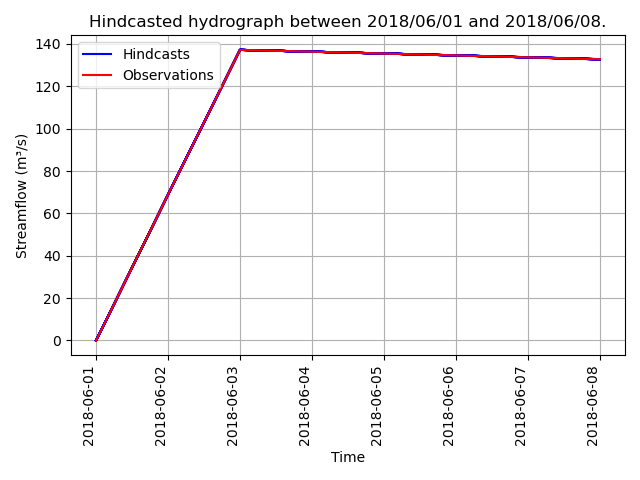

In [4]:
# Invent an observation so we can compute metrics later, and display as Qobs here. TODO: Add real streamflow data.
qq = hydrograph.isel(member=10)
qq.to_netcdf(str(tmp) + '/q_obs.nc','w')

resp_graph = wps.graph_forecast_uncertainty(qobs=str(tmp / 'q_obs.nc'), fcst=hydrograph_url, qobs_var='q_sim', fcst_var='q_sim')
resp_graph.get(asobj=True)[0]

 Now, we can compute hindcast scores such as CRPS for this hindcast. The computations use the XSkillScore library.

In [5]:
resp = wps.hindcast_evaluation(obs=str(tmp / 'q_obs.nc'), hcst=hydrograph_url, obs_var='q_sim', hcst_var='q_sim', metric='crps_ensemble')
[score] = resp.get(asobj=True)
print(score)

{'crps_ensemble': 0.004812794717866269}


## Ensemble streamflow prediction using ERA5

In [6]:
# We need to tell the model by how many hours we need to shift ERA5 data for it to be aligned on our catchment.
UTCoffset_hours = -6 # for UTC delta

#Perform the linear transform and time shift to shift ERA5 units to those expected by RAVEN.
nc_transforms=json.dumps({'tas': {'linear_transform': (1.0, -273.15), 'time_shift': UTCoffset_hours/24}, 'pr': {'linear_transform': (24000.0, 0.0), 'time_shift': UTCoffset_hours/24}})     

# Here the ERA5 data for the catchment was pre-extracted to keep things simple and running faster, but this could
#be a call to the ERA5 (or other dataset) extraction tools. 
ts = str(get_file("era5/tas_pr_LSJ_20140520-20180615.nc"))

# Call the service to get what we need.
resp_ESP = wps.climatology_esp(forecast_date=dt.datetime(2018,6,1),
                              forecast_duration=8,
                              ts=ts,
                              model_name='GR4JCN',
                              params='0.529, -3.396, 407.29, 1.072, 16.9, 0.947',
                              name='test',
                              area=basin_area,
                              latitude=basin_latitude,
                              longitude=basin_longitude,
                              elevation=basin_elevation,
                              nc_spec=nc_transforms, 
                              rvc=rvc,                           
                              rain_snow_fraction='RAINSNOW_DINGMAN' 
                              )


The model has run in climatology ESP mode, so extract and display the results.

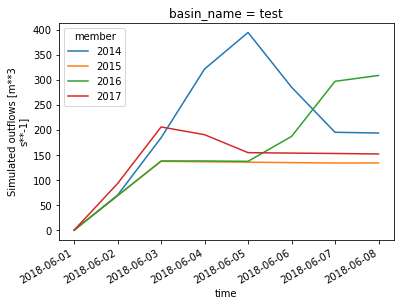

In [7]:
forecasts=resp_ESP.get(asobj=True)
forecasts.forecast.q_sim.plot.line(x='time')

We can now compute the performance score using XSkillScore again.

In [8]:
forecasts.forecast.to_netcdf(str(tmp) + '/fcst.nc','w')
resp = wps.hindcast_evaluation(obs=str(tmp / 'q_obs.nc'), hcst=str(tmp / 'fcst.nc'), obs_var='q_sim', hcst_var='q_sim', metric='crps_ensemble')
[score] = resp.get(asobj=True)
print(score)

{'crps_ensemble': 17.45754992611317}
